# Predicting credit default with XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem **_

_NOTE: This notebook was created and tested using the `Python 3 (Data Science)` kernel._

---

---

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Extensions](#Extensions)

---

## Background

The ability to forecast and discriminate is central in many medical situations. Standard statistical techniques such as discriminate
analysis, regression analysis, and factor analysis have been used to provide this ability. However, even with the existence of hidden
functional relationships that can provide forecasting ability, standard statistical techniques may be unsuccessful. The standard
statistical methods may provide disappointing results when:
1. The sample size is small.
2. The form of the underlying functional relationship is not known.
3. The underlying functional relationships involve complex interactions and intercorrelations among a number of variables.

These conditions are not unusual in medical problems. In such situations, neural network approaches offer promise.

In this notebook, we will be using the XGBoost algorithm to forecast the onset of non-insulin-dependent diabetes mellitus (DM) within a five-year period. The dataset used is a Public Domain dataset provided by the National Institute of Diabetes and Digestive and Kidney Diseases and first explored in [[1]](#ack-1).

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

We will be going through the following steps:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Install additional libraries

[Pandas profiling](https://github.com/pandas-profiling/pandas-profiling) works great for smaller datasets. Pandas profiling does not come preinstalled on the Data Science Kernel, but we can install it with pip.

In [22]:
!pip install pandas-profiling[notebook]

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## Preparation

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [23]:
import boto3
import re
import sagemaker # Amazon SageMaker's Python SDK provides many helper functions

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'sagemaker/credit-xgboost'
 
# Define IAM role
role = sagemaker.get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20201031T094356 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


In [24]:
(bucket,prefix,role)

('sagemaker-eu-west-1-641758013508',
 'sagemaker/credit-xgboost',
 'arn:aws:iam::641758013508:role/service-role/AmazonSageMaker-ExecutionRole-20201031T094356')

Now let's bring in the Python libraries that we'll use throughout the analysis

In [25]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker.deserializers                    # Converts strings for HTTP POST requests on inference

---

## Data

The dataset should already be available in the repository under the dataset folder. Now lets read this into a Pandas data frame and take a look.


In [26]:
data = pd.read_csv('./dataset/UCI_CC.csv', ';')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

ID LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  \
0          1     20000    2          2         1   24      2      2     -1   
1          2    120000    2          2         2   26     -1      2      0   
2          3     90000    2          2         2   34      0      0      0   
3          4     50000    2          2         1   37      0      0      0   
4          5     50000    1          2         1   57     -1      0     -1   
...      ...       ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996    220000    1          3         1   39      0      0      0   
29996  29997    150000    1          3         2   43     -1     -1     -1   
29997  29998     30000    1          2         2   37      4      3      2   
29998  29999     80000    1          3         1   41      1     -1      0   
29999  30000     50000    1          2         1   46      0      0      0   

       PAY_4  PAY_5  PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5  \
0         -1     -2     -2      3913      3102       689         0         0   
1          0      0      2      2682      1725      2682      3272      3455   
2          0      0      0     29239     14027     13559     14331     14948   
3          0      0      0     46990     48233     49291     28314     28959   
4          0      0      0      8617      5670     35835     20940     19146   
...      ...    ...    ...       ...       ...       ...       ...       ...   
29995      0      0      0    188948    192815    208365     88004     31237   
29996     -1      0      0      1683      1828      3502      8979      5190   
29997     -1      0      0      3565      3356      2758     20878     20582   
29998      0      0     -1     -1645     78379     76304     52774     11855   
29999      0      0      0     47929     48905     49764     36535     32428   

      BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6  \
0             0        0      689        0        0        0        0   
1          3261        0     1000     1000     1000        0     2000   
2         15549     1518     1500     1000     1000     1000     5000   
3         29547     2000     2019     1200     1100     1069     1000   
4         19131     2000    36681    10000     9000      689      679   
...         ...      ...      ...      ...      ...      ...      ...   
29995     15980     8500    20000     5003     3047     5000     1000   
29996         0     1837     3526     8998      129        0        0   
29997     19357        0        0    22000     4200     2000     3100   
29998     48944    85900     3409     1178     1926    52964     1804   
29999     15313     2078     1800     1430     1000     1000     1000   

       default.payment.next.month  
0                               1  
1                               1  
2                               0  
3                               0  
4                               0  
...                           ...  
29995                           0  
29996                           0  
29997                           1  
29998                           1  
29999                           1  

[30000 rows x 25 columns]

Let's talk about the data.  At a high level, we can see:

* We have 30000 user and their credits records
* 25 features per record
* The features are numeric
* The data is not sorted

_**Specifics on each of the features:**_

*Features:*
* `ID`: ID of user
* `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* `SEX`: Gender (1=male, 2=female)
* `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* `Marriage`: Marital status (1=married, 2=single, 3=other)
* `AGE`: Age in years
* `PAY_1`: Repayment status for this month. (-2=No consumption, -1=paid duly, 0=use of revolving credit, 1=payment delayed 1 month, 2=payment delayed 2 months, [...], 9=payment delayed 9 months or more)
* `PAY_2`: Repayment status for last month. (same as above)
* `PAY_3`: Repayment status for 2 months ago. (same as above)
* `PAY_4`: Repayment status for 3 months ago. (same as above)
* `PAY_5`: Repayment status for 4 months ago. (same as above)
* `PAY_6`: Repayment status for 5 months ago. (same as above)
* `BILL_AMT1`: Amount of bill this month.
* `BILL_AMT2`: Amount of bill last month.
* `BILL_AMT3`: Amount of bill 2 months ago.
* `BILL_AMT4`: Amount of bill 3 months ago.
* `BILL_AMT5`: Amount of bill 4 months ago.
* `BILL_AMT6`: Amount of bill 5 months ago.
* `PAY_AMT1`: Amount of payment made this month.
* `PAY_AMT2`: Amount of payment made last month.
* `PAY_AMT3`: Amount of payment made 2 months ago.
* `PAY_AMT4`: Amount of payment made 3 months ago.
* `PAY_AMT5`: Amount of payment made 4 months ago.
* `PAY_AMT6`: Amount of payment made 5 months ago.

*Target variable:*
* `default.payment.next.month`: Default payment next month (1=yes, 0=no).



### Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

In [27]:
from pandas_profiling import ProfileReport

profile_data = data
profile = ProfileReport(profile_data, title="Credit card default data set report")
profile

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Drop meaningless features

In [28]:
data = data.drop(['ID'], axis=1)

### Pre process data

In [29]:
# Calculates and deformats scientific notation, ie (5*10^5).
def remove_scientific_notation(value):
    if (type(value) == str) and ('^+' in value):
        new = value.replace('^+', 'e')
        sep = new.split('×')
        return int(sep[0])*int(float(sep[1]))
    return value
        
columns_to_deformat =  ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for colmn in columns_to_deformat:
    data[colmn] = data[colmn].apply(remove_scientific_notation)
data

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0         20000    2          2         1   24      2      2     -1     -1   
1        120000    2          2         2   26     -1      2      0      0   
2         90000    2          2         2   34      0      0      0      0   
3         50000    2          2         1   37      0      0      0      0   
4         50000    1          2         1   57     -1      0     -1      0   
...         ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995    220000    1          3         1   39      0      0      0      0   
29996    150000    1          3         2   43     -1     -1     -1     -1   
29997     30000    1          2         2   37      4      3      2     -1   
29998     80000    1          3         1   41      1     -1      0      0   
29999     50000    1          2         1   46      0      0      0      0   

       PAY_5  PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5  \
0         -2     -2      3913      3102       689         0         0   
1          0      2      2682      1725      2682      3272      3455   
2          0      0     29239     14027     13559     14331     14948   
3          0      0     46990     48233     49291     28314     28959   
4          0      0      8617      5670     35835     20940     19146   
...      ...    ...       ...       ...       ...       ...       ...   
29995      0      0    188948    192815    208365     88004     31237   
29996      0      0      1683      1828      3502      8979      5190   
29997      0      0      3565      3356      2758     20878     20582   
29998      0     -1     -1645     78379     76304     52774     11855   
29999      0      0     47929     48905     49764     36535     32428   

      BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6  \
0             0        0      689        0        0        0        0   
1          3261        0     1000     1000     1000        0     2000   
2         15549     1518     1500     1000     1000     1000     5000   
3         29547     2000     2019     1200     1100     1069     1000   
4         19131     2000    36681    10000     9000      689      679   
...         ...      ...      ...      ...      ...      ...      ...   
29995     15980     8500    20000     5003     3047     5000     1000   
29996         0     1837     3526     8998      129        0        0   
29997     19357        0        0    22000     4200     2000     3100   
29998     48944    85900     3409     1178     1926    52964     1804   
29999     15313     2078     1800     1430     1000     1000     1000   

       default.payment.next.month  
0                               1  
1                               1  
2                               0  
3                               0  
4                               0  
...                           ...  
29995                           0  
29996                           0  
29997                           1  
29998                           1  
29999                           1  

[30000 rows x 24 columns]

### MinMax scaler to numerical features

In [30]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

columns_to_scale = ['AGE', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

data


LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_1  PAY_2  PAY_3  \
0       0.001001    2          2         1  0.051724      2      2     -1   
1       0.011011    2          2         2  0.086207     -1      2      0   
2       0.008008    2          2         2  0.224138      0      0      0   
3       0.004004    2          2         1  0.275862      0      0      0   
4       0.004004    1          2         1  0.620690     -1      0     -1   
...          ...  ...        ...       ...       ...    ...    ...    ...   
29995   0.021021    1          3         1  0.310345      0      0      0   
29996   0.014014    1          3         2  0.379310     -1     -1     -1   
29997   0.002002    1          2         2  0.275862      4      3      2   
29998   0.007007    1          3         1  0.344828      1     -1      0   
29999   0.004004    1          2         1  0.431034      0      0      0   

       PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
0         -1     -2     -2   0.145415   0.017907   0.037994   0.053628   
1          0      0      2   0.144359   0.017569   0.038474   0.054660   
2          0      0      0   0.167143   0.020592   0.041090   0.058149   
3          0      0      0   0.182373   0.028997   0.049685   0.062560   
4          0      0      0   0.149451   0.018538   0.046449   0.060233   
...      ...    ...    ...        ...        ...        ...        ...   
29995      0      0      0   0.304164   0.064522   0.087949   0.081389   
29996     -1      0      0   0.143502   0.017594   0.038671   0.056460   
29997     -1      0      0   0.145117   0.017970   0.038492   0.060214   
29998      0      0     -1   0.140647   0.036404   0.056183   0.070276   
29999      0      0      0   0.183178   0.029162   0.049799   0.065153   

       BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0       0.019928   0.253510  0.000000  0.000230  0.000000  0.000000  0.000000   
1       0.020775   0.255944  0.000000  0.000333  0.001000  0.000500  0.000000   
2       0.023591   0.265117  0.000506  0.000500  0.001000  0.000500  0.000333   
3       0.027024   0.275567  0.000667  0.000673  0.001200  0.000550  0.000356   
4       0.024619   0.267791  0.000667  0.012227  0.010000  0.004500  0.000230   
...          ...        ...       ...       ...       ...       ...       ...   
29995   0.027582   0.265439  0.002833  0.006667  0.005003  0.001523  0.001667   
29996   0.021200   0.253510  0.000612  0.001175  0.008998  0.000064  0.000000   
29997   0.024971   0.267960  0.000000  0.000000  0.022000  0.002100  0.000667   
29998   0.022833   0.290046  0.028633  0.001136  0.001178  0.000963  0.017655   
29999   0.027874   0.264941  0.000693  0.000600  0.001430  0.000500  0.000333   

       PAY_AMT6  default.payment.next.month  
0      0.000000                           1  
1      0.001000                           1  
2      0.002500                           0  
3      0.000500                           0  
4      0.000339                           0  
...         ...                         ...  
29995  0.000500                           0  
29996  0.000000                           0  
29997  0.001550                           1  
29998  0.000902                           1  
29999  0.000500                           1  

[30000 rows x 24 columns]

### One-hot encode categorical values

In [31]:
# columns_to_onehot_encode = ['SEX', 'EDUCATION', 'MARRIAGE']#, 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

#for column in columns_to_onehot_encode:
#    data = pd.concat([pd.get_dummies(data[column], prefix=column), data.drop([column], axis=1)])
    
#data

### Move target column to first column. SageMaker assumes first column is target.

In [32]:
data = data[ ['default.payment.next.month'] + [ col for col in data.columns if col != 'default.payment.next.month' ] ]

### Split data

In [33]:
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10% 

In [34]:
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')


In [35]:
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='latest')

In [36]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [37]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-05-06 06:06:16 Starting - Starting the training job...
2021-05-06 06:06:40 Starting - Launching requested ML instancesProfilerReport-1620281176: InProgress
......
2021-05-06 06:07:40 Starting - Preparing the instances for training......
2021-05-06 06:08:45 Downloading - Downloading input data...
2021-05-06 06:09:02 Training - Downloading the training image..Arguments: train
[2021-05-06:06:09:24:INFO] Running standalone xgboost training.
[2021-05-06:06:09:24:INFO] File size need to be processed in the node: 6.65mb. Available memory size in the node: 8401.63mb
[2021-05-06:06:09:24:INFO] Determined delimiter of CSV input is ','
[06:09:24] S3DistributionType set as FullyReplicated
[06:09:24] 21000x23 matrix with 483000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-06:06:09:24:INFO] Determined delimiter of CSV input is ','
[06:09:24] S3DistributionType set as FullyReplicated
[06:09:24] 6000x23 matrix with 138000 entries loaded from /opt/ml/

### Deploy model

In [38]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------------!

In [39]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer() 

In [41]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['default.payment.next.month'], axis=1).to_numpy())

In [42]:
pd.crosstab(index=test_data['default.payment.next.month'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions']) 

predictions   0.0  1.0
actuals               
0            2221  119
1             407  253

In [49]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(np.round(predictions), test_data['default.payment.next.month'])

print('precision: ', average_precision)

precision:  0.3003745519713262


In [43]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_data['default.payment.next.month'], predictions)
roc_auc = auc(fpr, tpr)

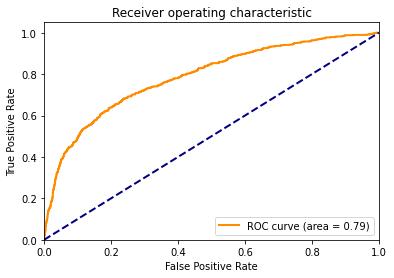

In [44]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
xgb_predictor.delete_endpoint()